In [1]:
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2025-03-06 16:48:43.641531: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 16:48:43.653592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741276123.667555   60631 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741276123.671093   60631 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 16:48:43.686497: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
class PreprocessingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(PreprocessingLayer, self).__init__(**kwargs)

    def call(self, inputs):
        min_val = tf.reduce_min(inputs, axis=0)
        max_val = tf.reduce_max(inputs, axis=0)
        normalized_inputs = tf.where(
            max_val - min_val != 0,
            (inputs - min_val) / (max_val - min_val + 1e-8),
            tf.zeros_like(inputs),
        )
        return normalized_inputs

In [3]:
class Autoencoder:
    """Autoencoder that reconstruct METSig distributions and flag anomalies"""

    def __init__(self, input_shape: tuple[int], l2_lambda: float):
        input_layer = tf.keras.Input(shape=input_shape)
        prep_layer = PreprocessingLayer()(input_layer)
        encoded = tf.keras.layers.Dense(18, activation="relu", activity_regularizer=tf.keras.regularizers.l2(l2_lambda))(prep_layer)
        encoded = tf.keras.layers.Dense(8, activation="sigmoid")(encoded)
        decoded = tf.keras.layers.Dense(18, activation="sigmoid")(encoded)
        decoded = tf.keras.layers.Dense(input_shape[0], activation="sigmoid")(decoded)
        self.model = tf.keras.models.Model(input_layer, decoded)

        # Since `avg_mse` shares the same layers (prep_layer and decoded) as the `self.model`
        # this `self.stripped_model` doesn't need to be trained
        avg_mse = tf.keras.losses.MSE(prep_layer, decoded)  # Compute the mean squared error for each row in the inputs
        self.stripped_model = tf.keras.models.Model(input_layer, avg_mse)

    def compile(self):
        self.model.compile(optimizer="adam", loss=["mse"], metrics=["mse"])

    def summary(self):
        self.model.summary()

    def predict(self, inputs: np.ndarray):
        return self.model.predict(inputs)

    def fit(self, inputs: np.ndarray, batch_size: int, epochs: int):
        targets = PreprocessingLayer()(inputs)
        history: tf.keras.callbacks.History = self.model.fit(
            inputs, targets, batch_size=batch_size, epochs=epochs
        )
        return history

In [4]:
train_data = np.load("../data/data.npy")
train_label = np.load("../data/label.npy")

# We want to feed the Autoencoder with GOOD data, so we filter the data by the label == 1
train_data = train_data[train_label == 1]
train_data

array([[1940., 1987.,  670., ...,    0.,    0.,    0.],
       [1869., 1872.,  714., ...,    0.,    0.,    0.],
       [1819., 1924.,  672., ...,    0.,    0.,    0.],
       ...,
       [ 987.,  745.,  264., ...,    0.,    0.,    0.],
       [ 978.,  794.,  201., ...,    0.,    0.,    0.],
       [ 924.,  743.,  234., ...,    0.,    0.,    0.]])

In [5]:
ae = Autoencoder(input_shape=(51,), l2_lambda=1e-4)
ae.compile()
ae.summary()

2025-03-06 16:48:45.618613: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 51)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocessing_layer             │ (None, 51)             │             0 │
│ (PreprocessingLayer)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18)             │           936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 18)             │           162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 51)             │           969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,219 (8.67 KB)

 Trainable params: 2,219 (8.67 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = ae.fit(train_data, 128, 20)

Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2104 - mse: 0.2031  
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0669 - mse: 0.0661  
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0223 - mse: 0.0222
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118 - mse: 0.0117
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0083 - mse: 0.0083
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - mse: 0.0067
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - mse: 0.0059
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - mse: 0.0053
Epoch 9/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - mse: 0.0051
Epoch 10/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 - mse: 0.0048
Epoch 11/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 - mse: 0.0046
Epoch 12/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045 - mse: 0.0045
Epoch 13/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

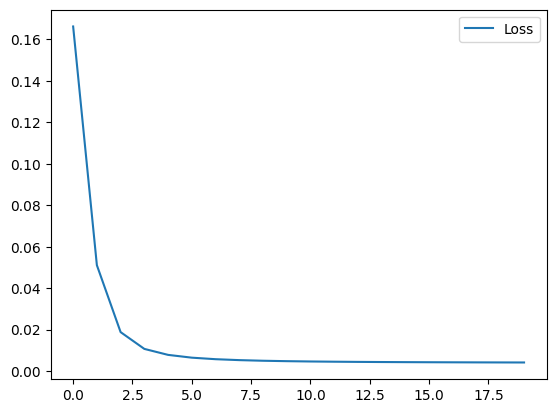

In [7]:
plt.plot(history.history['loss'], label="Loss")
plt.legend()
plt.show()

In [11]:
ae.model.predict(train_data)

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step


array([[0.65870476, 0.5869801 , 0.4615482 , ..., 0.01536431, 0.01390053,
        0.0118917 ],
       [0.65870494, 0.58697134, 0.46153417, ..., 0.01536665, 0.01390366,
        0.01189429],
       [0.65870494, 0.58697134, 0.46153417, ..., 0.01536665, 0.01390366,
        0.01189429],
       ...,
       [0.65870494, 0.58697134, 0.46153417, ..., 0.01536665, 0.01390366,
        0.01189429],
       [0.6587037 , 0.58705246, 0.46166405, ..., 0.01534523, 0.01387497,
        0.01187051],
       [0.65870494, 0.58697134, 0.46153417, ..., 0.01536665, 0.01390366,
        0.01189429]], dtype=float32)

In [12]:
ae.stripped_model.summary()
ae.stripped_model.predict(train_data)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocessing_layer │ (None, 51)        │          0 │ input_layer[0][0] │
│ (PreprocessingLaye… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 18)        │        936 │ preprocessing_la… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8)         │        152 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 18)        │        162 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 51)        │        969 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convert_to_tensor_1 │ (None, 51)        │          0 │ preprocessing_la… │
│ (ConvertToTensor)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convert_to_tensor   │ (None, 51)        │          0 │ dense_3[0][0]     │
│ (ConvertToTensor)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 51)        │          0 │ convert_to_tenso… │
│                     │                   │            │ convert_to_tenso… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ square (Square)     │ (None, 51)        │          0 │ subtract[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Mean)         │ (None)            │          0 │ square[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,219 (8.67 KB)

 Trainable params: 2,219 (8.67 KB)

 Non-trainable params: 0 (0.00 B)

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


array([0.04347204, 0.04621698, 0.05846943, ..., 0.06531066, 0.02644791,
       0.04460311], dtype=float32)

In [13]:
os.makedirs("../models/tensorflow", exist_ok=True)

model_path = "../models/tensorflow/1/"
tf.saved_model.save(ae.stripped_model, model_path)

# We could save the full model, by referencing ae.model

INFO:tensorflow:Assets written to: ../models/tensorflow/1/assets


INFO:tensorflow:Assets written to: ../models/tensorflow/1/assets
